<a href="https://colab.research.google.com/github/anaconda121/CTC/blob/main/CTC_Systematic_Equities_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as plt
from collections import defaultdict
import math
import matplotlib.pyplot as plt

# Systematic Equities Case Study

In [2]:
emerging_market_countries = ['BRA','MEX','IND','CHN','ZAF']
developed_market_countries = ['USA','JPN','DEU','GBR','FRA']

columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # total data
features = ['Open', 'Close', 'High', 'Low', 'Volume'] # input features

# start and end dates for data collection, should be modified by CQF when evaluating strategy
START_DATE = "2015-01-01"
END_DATE = "2023-01-01"

In [3]:
# example of portfolio:
# keys: countries, values: array of five stock tickers.

portfolio = {
            'BRA': ['PBR','VALE','ITUB','NU','BSBR'],
            'MEX': ['AMX','KCDMY','VLRS','ALFAA.MX','BBAJIOO.MX'],
            'IND': ['RELIANCE.NS','TCS', 'HDB', 'INFY', 'ADANIENT.NS'],
            'USA': ['AAPL', 'MSFT','GOOG','AMZN','NVDA']
            }

stock_mapping = {}
for country in portfolio:
    for stock in portfolio[country]:
        stock_mapping[stock] = country

In [4]:
def get_data(portfolio, start_date, end_date):
    # Initialize an empty DataFrame
    data = pd.DataFrame()

    # Create an empty list for columns
    columns = []

    # Loop through each country in the portfolio
    for country, tickers in portfolio.items():
        # Download data for each ticker
        df = yf.download(tickers, start=start_date, end=end_date)

        # Extract the columns representing stock attributes (e.g., 'Adj Close', 'Volume', etc.)
        stock_attributes = df.columns.levels[0]

        # Extend the list of columns with country and attribute prefix
        country_columns = [(country, attr, ticker) for ticker in tickers for attr in stock_attributes]
        columns.extend(country_columns)

        # Concatenate the data to the main DataFrame
        data = pd.concat([data, df], axis=1)

    # Create a multi-index header
    data.columns = pd.MultiIndex.from_tuples(columns)
    return data

In [5]:
data = get_data(portfolio, start_date=START_DATE, end_date=END_DATE)
data.interpolate(method = 'linear', inplace = True,limit_direction = 'both')

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


In [6]:
def generate_individal_equity_data(portfolio, data):
    equity_dfs = {}
    ticker_list = []

    for country in portfolio:
        for stock in portfolio[country]:
            df = pd.DataFrame(data.index) # initializing default df to have dates from 01-01-2023 -> 10-04-2023
            ticker_list.append(stock)
            for col in columns:
                col_data = data[country][col][stock].reset_index() # assigning equity data to df
                df[col] = col_data[stock]
            equity_dfs[stock] = df

    return equity_dfs

def generate_predicted_returns(df):
    # computing daily return
    daily_return_vals = []
    for i, row in df.iterrows():
        if (i == 0):
            daily_return_vals.append(0)
        else:
            ret = (df.loc[[i]]["EWMA-30"][i]) / (df.loc[[i-1]]["EWMA-30"][i-1]) - 1.00
            daily_return_vals.append(ret)

    # getting next day return to use as output feature
    next_day_return = []
    for i, row in df.iterrows():
        if (i == len(df) - 1):
            next_day_return.append(0)
        else:
            next_day_return.append(daily_return_vals[i + 1])

    return next_day_return

In [8]:
def strategy(portfolio, start_date, end_date):
    data = get_data(portfolio, start_date=start_date, end_date=end_date)
    data.interpolate(method = 'linear', inplace = True, limit_direction = 'both')
    equity_dfs = generate_individal_equity_data(portfolio, data)
    trading_list = pd.DataFrame(columns = data.columns.levels[2])

    for ticker in data.columns.levels[2]:
        curr_data = equity_dfs[ticker]
        curr_data["EWMA-30"] = curr_data["Adj Close"].ewm(span = 30).mean()
        curr_data["EWMA-30"] = curr_data["EWMA-30"].shift(1)
        curr_data["Next Day Returns"] = generate_predicted_returns(curr_data)
        ticker_trades = pd.DataFrame(columns = [ticker])

        row_counter = 0
        for dates in curr_data["Date"]:
            if curr_data.loc[[row_counter]]["Next Day Returns"][row_counter] > 0:
                ticker_trades.loc[dates] = 1
            else:
                ticker_trades.loc[dates] = -1
            row_counter += 1

        trading_list[ticker] = ticker_trades

    trading_list_one = trading_list.sub(trading_list.mean(axis=1), axis=0)
    trading_list_normalized = trading_list_one.div(trading_list_one.abs().sum(axis=1), axis=0)
    return trading_list_normalized

In [9]:
trading_list = strategy(portfolio, start_date=START_DATE,end_date=END_DATE)
trading_list.head(5)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778
2015-01-05,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-06,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,0.166667,-0.029412
2015-01-07,0.055556,-0.045455,0.055556,0.055556,-0.045455,-0.045455,0.055556,-0.045455,0.055556,-0.045455,-0.045455,0.055556,-0.045455,-0.045455,-0.045455,0.055556,-0.045455,0.055556,0.055556,-0.045455


In [10]:
'''
Given a trading list check to see if the portfolio weights sum to 0 and if the
 absolute value of the weights sum to 1.
'''

def check_long_short(trading_list):
    vals = trading_list.sum(axis = 1)
    abs_vals = trading_list.abs().sum(axis = 1)
    def is_close_to_zero(value, threshold=1e-6):
        return abs(value) <= threshold

    def is_close_to_one(value, threshold=(1+1e-6)):
        return abs(value) <= threshold

    # Apply the function to all elements in the Series
    result = vals.apply(lambda x: is_close_to_zero(x))
    result_ones = abs_vals.apply(lambda x: is_close_to_one(x))
    # Check if all values are close to 0
    all_close_to_zero = result.all()
    # Check if all values are close to 1
    all_close_to_one= result_ones.all()
    return all_close_to_zero, all_close_to_one

In [11]:
check_long_short(trading_list)

(True, True)

In [12]:
'''
check to see if the daily turn over is less than the treshold (0.25)
'''
def check_turn_over(trading_list, treshold):
    abs_turn_over = trading_list.diff().abs().sum(axis = 1)

    def is_close_to_turnover(value, threshold=(treshold+1e-6)):
        return abs(value) <= threshold

    # Apply the function to all elements in the Series
    result_turnover = abs_turn_over.apply(lambda x: is_close_to_turnover(x))
    # Check if all values are close to 0
    all_close_to_turnover = result_turnover.all()
    return all_close_to_turnover

In [13]:
check_turn_over(trading_list, 0.25)

False

In [14]:
trading_list

,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778
2015-01-05,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-06,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,0.166667,-0.029412
2015-01-07,0.055556,-0.045455,0.055556,0.055556,-0.045455,-0.045455,0.055556,-0.045455,0.055556,-0.045455,-0.045455,0.055556,-0.045455,-0.045455,-0.045455,0.055556,-0.045455,0.055556,0.055556,-0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000
2022-12-27,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000
2022-12-28,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000
2022-12-29,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,-0.033333,0.100000,-0.033333,0.100000,-0.033333,0.100000


trading_list

1000

APPL: 0.5 (50)   --> $500   AMZN: -0.5 (50) --> $-500
APPL: 0.3  (60) -->     AMZN: 0.7 (30) -->

200/60 -> 3.333, -> 33.333
1000
APPL:
0.2               1.2



P = 1000
[APPL, AMZN, GOOG, TSLA]
DAY 1: [0.25,0.25,-0.25,-0.25]
APPL: 50, AMZN: 20, GOOG: 30, TSLA: 40
5, 12.5, 8.33, 6.25

DAY 2: [0.3,0.2,-0.4,-0.1]
APPL: 60, : 10, GOOG: 50, TSLA: 40
APPL: 5+50/60(300), 12.5





In [15]:
'''
Overview: given a trading list of portfolio holdings use yfinance to find the
overall pnl.

# check PNL is not negative

# if you loose all your money your done
# make sure all dates are within bounds
# make sure dates are every day
# make sure dates are order
# make sure weights sum to 0 and absolute value to 1
#
#weights after closing day
'''

def backtest(trading_list: pd.DataFrame,x_list, y_list) -> None:
   check_date(trading_list)
   check_weights(trading_list)
   check_pnl(trading_list,x_list, y_list)


   # new_list = trading_list.copy(deep=True)
   # new_row = {'AAPL': 1, 'GOOG': np.nan}
   # new_list.loc["1"] = new_row
   # check_date(new_list)
   # new_list.loc[pd.to_datetime("2023-01-01")] = new_row
   # check_weights(new_list)
   # check_date(new_list)
# "will be sent in two days"

def check_weights(trading_list: pd.DataFrame) -> None:
   assert (trading_list.isna().all(axis=1) | trading_list.notna().all(axis=1)).all(), "There is a row with some, but not all NaN values"

   row_sums = abs(trading_list.sum(axis=1)) < 1e-5
   assert row_sums.all(), "Weights do not add up to zero"

   row_sums_abs = abs(trading_list.abs().sum(axis=1)) - 1 < 1e-5
   assert row_sums_abs.all(), "Absolute values of weights do not add up to one"

def calculate_money(index, holdings, values):
   if holdings == {}:
      return sum(values.values())
   value = 0
   for stock in holdings:
      num_stock = holdings[stock]
      country = stock_mapping[stock]
      stock_value_eod = data[country]['Adj Close'].loc[index][stock]
      if math.isnan(stock_value_eod):
         value += values[stock]
      else:
         value += num_stock*stock_value_eod
   return value

# Make Sure PNL is not negative and if at any moment your money is 0, you are done.
def check_pnl(trading_list: pd.DataFrame,x_list, y_list) -> None:
   stock_holdings = defaultdict(float)
   stock_holdings_values = defaultdict(float)
   for stock in stock_mapping:
      stock_holdings_values[stock] = 100000/len(stock_mapping)

   for cur_day, row in trading_list.iterrows():
      if row.isna().all():
         continue

      cur_money = calculate_money(cur_day, stock_holdings,stock_holdings_values) # sold everything
      build = 0
      for stock, weight in row.items():
         num_stocks_value = cur_money * weight
         country = stock_mapping[stock]
         stock_value_eod = data[country]['Adj Close'].loc[cur_day][stock]
         if weight < 0:
            stock_holdings[stock] = num_stocks_value / stock_value_eod if not math.isnan(stock_value_eod) else stock_holdings[stock]
            stock_holdings_values[stock] = num_stocks_value
         else:
            stock_holdings[stock] = 3*num_stocks_value / stock_value_eod if not math.isnan(stock_value_eod) else stock_holdings[stock]
            stock_holdings_values[stock] = 3*num_stocks_value

         build += stock_holdings_values[stock]
      x_list.append(cur_day)
      y_list.append(build)
      assert build > 0 , "you lost all your money"

def check_date(trading_list: pd.DataFrame) -> None:
   assert all(isinstance(idx, pd.Timestamp) for idx in trading_list.index), "An index is not a datetime object"

   start_date = pd.to_datetime('2015-01-01')
   end_date = pd.to_datetime('2023-01-01')
   all_within_timeframe = (trading_list.index >= start_date) & (trading_list.index <= end_date)
   assert all(all_within_timeframe), "You have elements outside of the date range"

   assert len(set(trading_list.index)) == len(trading_list.index), "Cannot have rows with duplicate dates"

   assert len(data.index) == len(trading_list.index), "Need to cover all days"

   assert list(trading_list.index) == list(data.index), "Rows must be in order"

In [16]:
time_stamps = []
pnl_on_day = []
backtest(trading_list,time_stamps,pnl_on_day)

Text(0, 0.5, 'PNL')

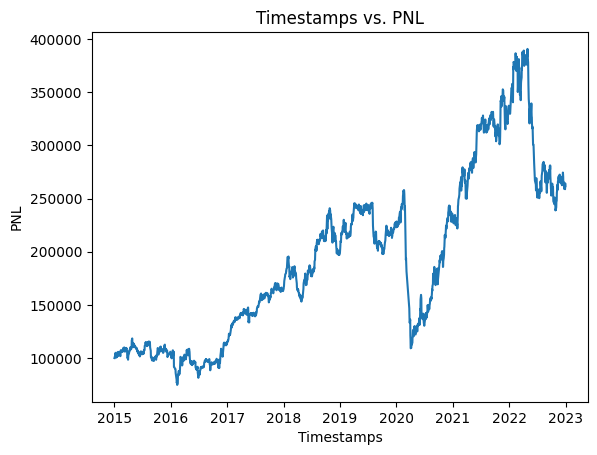

In [17]:
plt.plot(time_stamps,pnl_on_day)
plt.title('Timestamps vs. PNL')
plt.xlabel('Timestamps')
plt.ylabel('PNL')